### Import Libraries

In [1]:
## import libraries
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from scipy.stats import pointbiserialr
from collections import Counter


In [155]:
# download packages
nltk.download('punkt_tabs')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading punkt_tabs: Package 'punkt_tabs' not found
[nltk_data]     in index
[nltk_data] Downloading package stopwords to /Users/helda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/helda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Import Dataset

In [3]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))
from src.data.preprocessing import preprocessing

df_raw = pd.read_csv('../Data/Raw/Job_Frauds.csv', encoding='latin-1')
df = preprocessing(df_raw)

In [4]:
df.head(3)

,Job Title,Department,Range_of_Salary,Profile,Job_Description,Requirements,Job_Benefits,Telecomunication,Comnpany_Logo,Type_of_Employment,Experience,Qualification,Type_of_Industry,Operations,Fraudulent,Country,State,City
0,marketing intern,marketing,NaN,food52 weve created groundbreaking awardwinnin...,food52 fastgrowing james beard awardwinning on...,experience content management system major plu...,unknown,0,1,other,internship,unknown,unknown,marketing,0,us,ny,new york
1,customer service cloud video production,success,NaN,90 second world cloud video production service...,organised focused vibrant awesomedo passion cu...,expect youyour key responsibility communicate ...,get usthrough part 90 second team gainexperien...,0,1,fulltime,not applicable,unknown,marketing advertising,customer service,0,nz,,auckland
2,commissioning machinery assistant cma,unknown,NaN,valor service provides workforce solution meet...,client located houston actively seeking experi...,implement precommissioning commissioning proce...,unknown,0,1,unknown,unknown,unknown,unknown,unknown,0,us,ia,wever


## EDA

#### Analysis of Fraudulent posting across countries

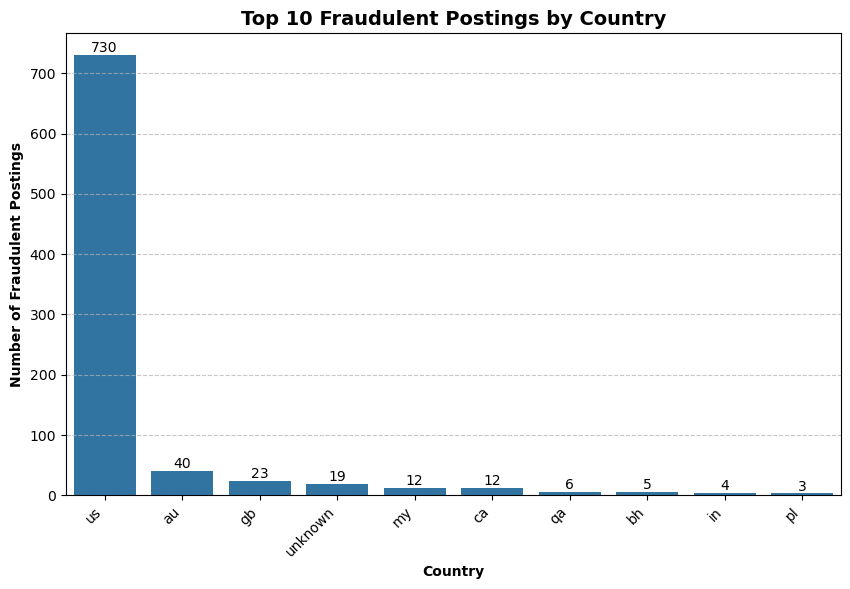

In [158]:
# Top 10 countries with highest fradulent job posting 

top_10_country = df.groupby('Country')['Fraudulent'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_country.index, y=top_10_country.values, estimator=sum, errorbar=None)
plt.title('Top 10 Fraudulent Postings by Country', fontsize=14, fontweight='bold')
plt.xlabel('Country', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()



##### Filter for only U.S. 

In [159]:
## Filter for US 
df = df[df['Country'] == 'us']
df = df.drop(['State','Country'], axis=1)

#### Missing Values Analysis

In [160]:
# Replace empty string, empty list as NaN
def replace_empty_values(x):
    if isinstance(x, str) and x.strip() == '':
        return np.nan
    elif isinstance(x, list) and len(x) == 0:
        return np.nan
    elif isinstance(x, (list, np.ndarray)) and len(x) == 0:
        return np.nan
    elif x is None:
        return np.nan
    else:
        return x

df = df.map(lambda x: replace_empty_values(x))


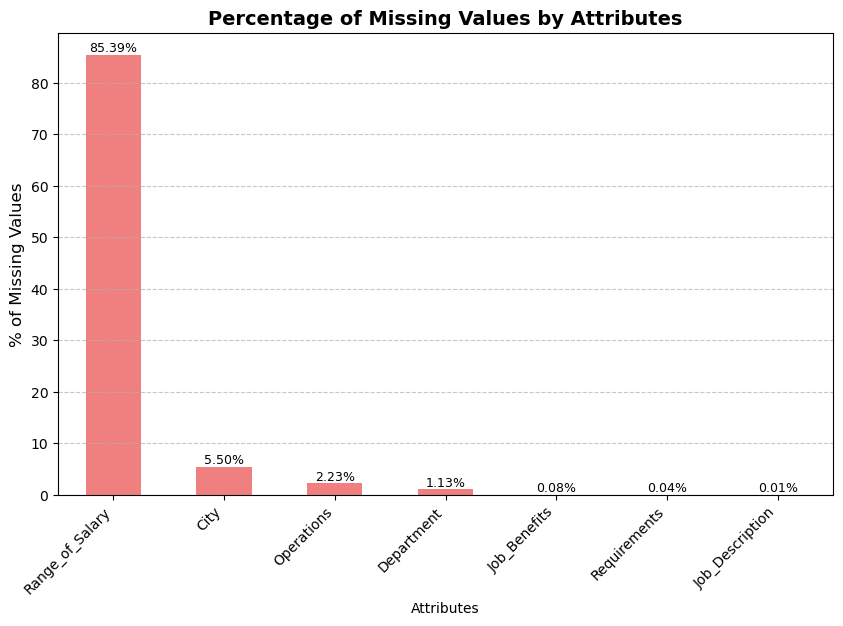

In [161]:
# Distribution of missing values across attributes

missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = missing_percent.plot(kind='bar', color='lightcoral')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

plt.title('Percentage of Missing Values by Attributes', fontsize=14, fontweight='bold')
plt.ylabel('% of Missing Values', fontsize=12)
plt.xlabel('Attributes', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


#### Relationship of missing values with fradulent postings

         Attribute  Correlation       P-Value  Adjusted P-Value
6             City     0.081245  4.479131e-17      3.135392e-16
1  Range_of_Salary    -0.078182  6.374018e-16      2.230906e-15
5       Operations     0.036945  1.364189e-04      3.183107e-04
2  Job_Description     0.035723  2.257007e-04      3.949762e-04
0       Department    -0.025421  8.682642e-03      1.215570e-02
4     Job_Benefits    -0.007885  4.157411e-01      4.850313e-01
3     Requirements    -0.005255  5.875273e-01      5.875273e-01
Missing Value Not significant: ['Job_Benefits', 'Requirements']


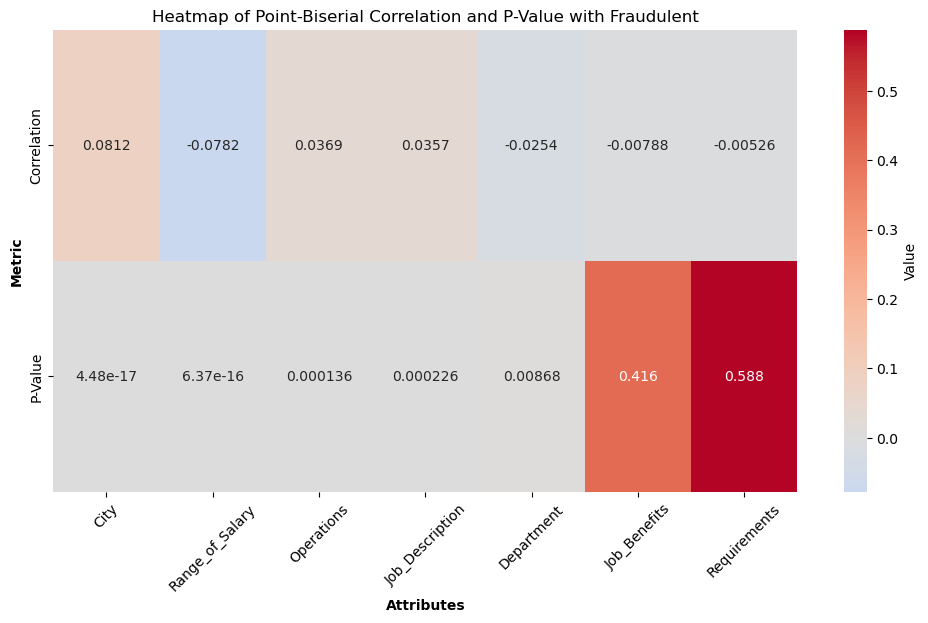

In [ ]:
# Compute the correlation and p-value between missing values and 'Fraudulent' occurrences.

# Create Missing Value Indicators (1 if missing, 0 if present)
missing_indicators = df.isna().astype(int)

correlation_results = []

for col in df.columns:
    if col != 'Fraudulent' and missing_indicators[col].sum() > 0:
        # Compute Point-Biserial Correlation and P-Value
        corr, p_value = pointbiserialr(missing_indicators[col], df['Fraudulent'])
        correlation_results.append([col, corr, p_value])

# Create DataFrame
correlation_df = pd.DataFrame(correlation_results, columns=['Attribute', 'Correlation', 'P-Value'])

# Apply FDR correction
correlation_df['Adjusted P-Value'] = multipletests(correlation_df['P-Value'], method='fdr_bh')[1]
correlation_df = correlation_df.sort_values(by='P-Value')

print(correlation_df)

# Identify non-significant columns (adjusted p-value > 0.05)
non_significant_columns = correlation_df[correlation_df['Adjusted P-Value'] > 0.05]['Attribute'].str.replace(r'\*\*', '', regex=True).tolist()
print("Missing Value Not significant:", non_significant_columns)


correlation_pvalue_df = correlation_df[['Attribute', 'Correlation', 'P-Value']].copy()
correlation_pvalue_df = correlation_pvalue_df.set_index('Attribute')
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_pvalue_df.T, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Value'}, fmt='.3g')
plt.xticks(rotation=45)
plt.xlabel('Attributes', fontweight = 'bold')
plt.ylabel('Metric', fontweight = 'bold')
plt.title('Heatmap of Point-Biserial Correlation and P-Value with Fraudulent')
plt.show()


#### Imputation of missing values

In [ ]:
# These columns (city, range of salary) are statistically significant when unspecified/specified, hence we create missing indicator columns 
df['Salary_Specified'] = df['Range_of_Salary'].notna()
df['City_Specified'] = df['City'].notna()

In [99]:
# Replace null values with 'Unspecified' category
df = df.fillna("Unspecified")

In [102]:
#Impute with median to instead of replacing with 0 to prevent increasing bias
df['Range_of_Salary'] = pd.to_numeric(df['Range_of_Salary'], errors='coerce')
median_salary = df['Range_of_Salary'].median()
df['Range_of_Salary'] = df['Range_of_Salary'].fillna(median_salary).astype(int)


#### Relationship of Employment Type with Fradulent Postings

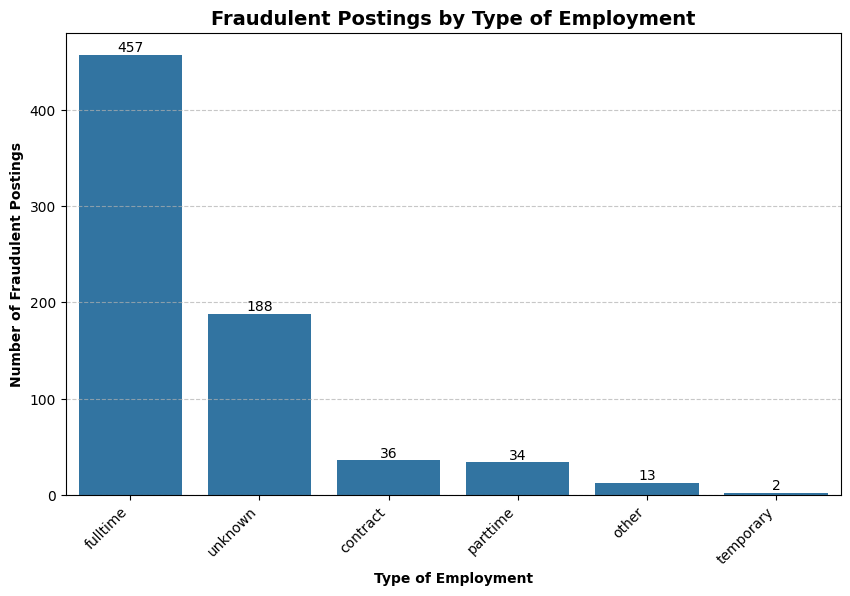

In [ ]:
# Barplot for Fraudulent Postings by type of employment 

sorted_employment = df.groupby('Type_of_Employment')['Fraudulent'].sum().sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='Type_of_Employment', y='Fraudulent', estimator=sum, errorbar=None, order=sorted_employment)
plt.title('Fraudulent Postings by Type of Employment', fontsize=14, fontweight='bold')
plt.xlabel('Type of Employment', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')
plt.show()


#### Relationship of Experience with Fradulent Postings

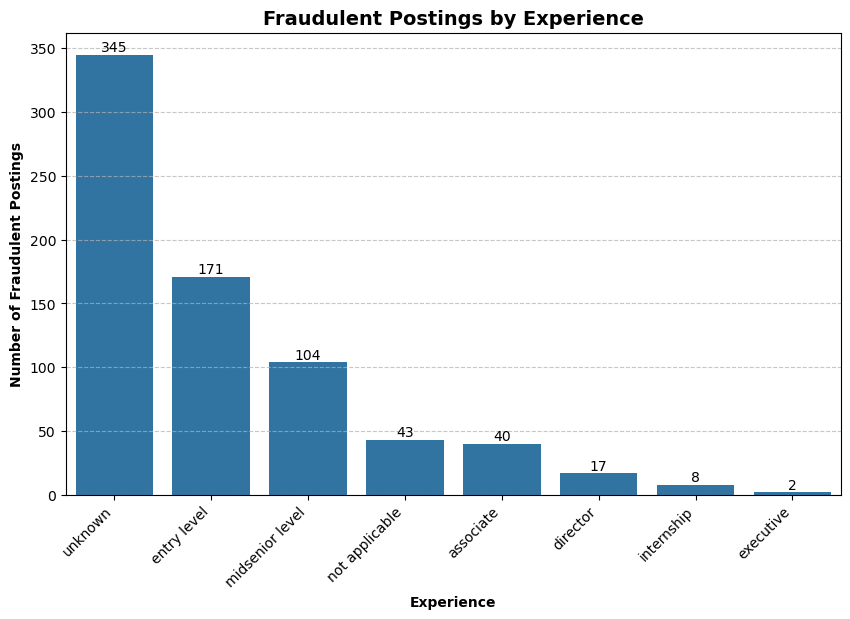

In [68]:
# Barplot for Fraudulent Postings by Experience

sorted_experience = df.groupby('Experience')['Fraudulent'].sum().sort_values(ascending=False).index
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='Experience', y='Fraudulent', estimator=sum, errorbar=None, order=sorted_experience)
plt.title('Fraudulent Postings by Experience', fontsize=14, fontweight='bold')
plt.xlabel('Experience', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')
plt.show()


#### Relationship of Qualification Type with Fradulent Postings

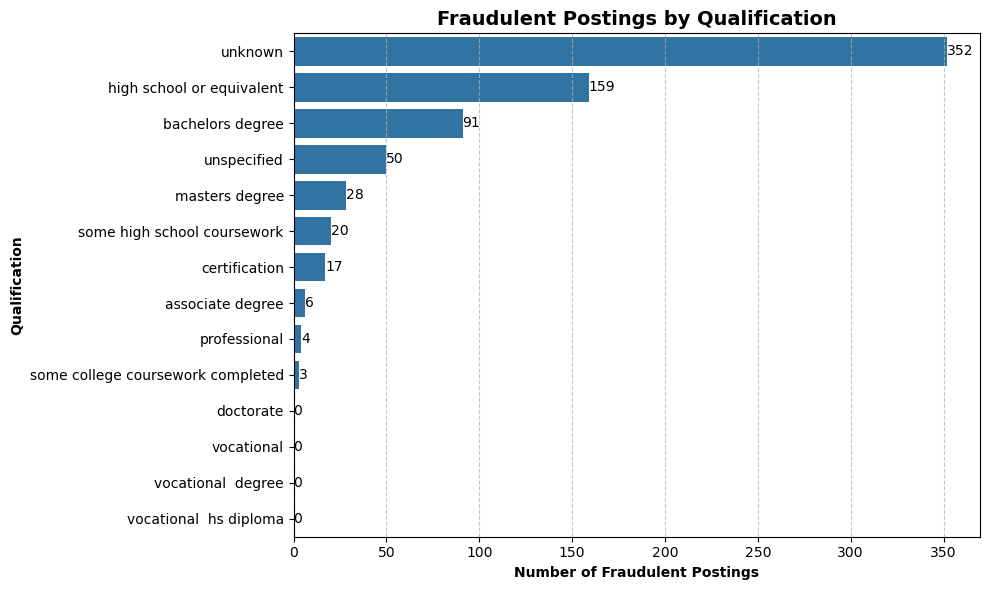

In [75]:
sorted_qualification = df.groupby('Qualification')['Fraudulent'].sum().sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, y='Qualification', x='Fraudulent', estimator=sum, errorbar=None, order=sorted_qualification)
plt.title('Fraudulent Postings by Qualification', fontsize=14, fontweight='bold')
plt.xlabel('Number of Fraudulent Postings', fontweight='bold')
plt.ylabel('Qualification', fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


#### Relationship of Industry Type with Fradulent Postings

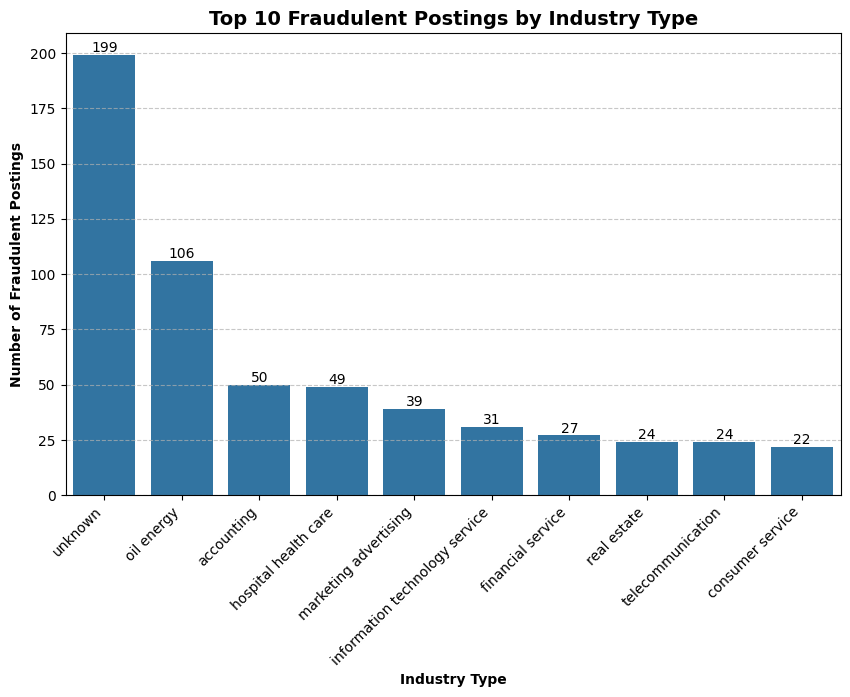

In [20]:
# Top 10 Industries with highest fradulent job posting

top_10_industry = df.groupby('Type_of_Industry')['Fraudulent'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_industry.index, y=top_10_industry.values, estimator=sum, errorbar=None)
plt.title('Top 10 Fraudulent Postings by Industry Type', fontsize=14, fontweight='bold')
plt.xlabel('Industry Type', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()


#### Relationship of Operation Type with Fradulent Postings

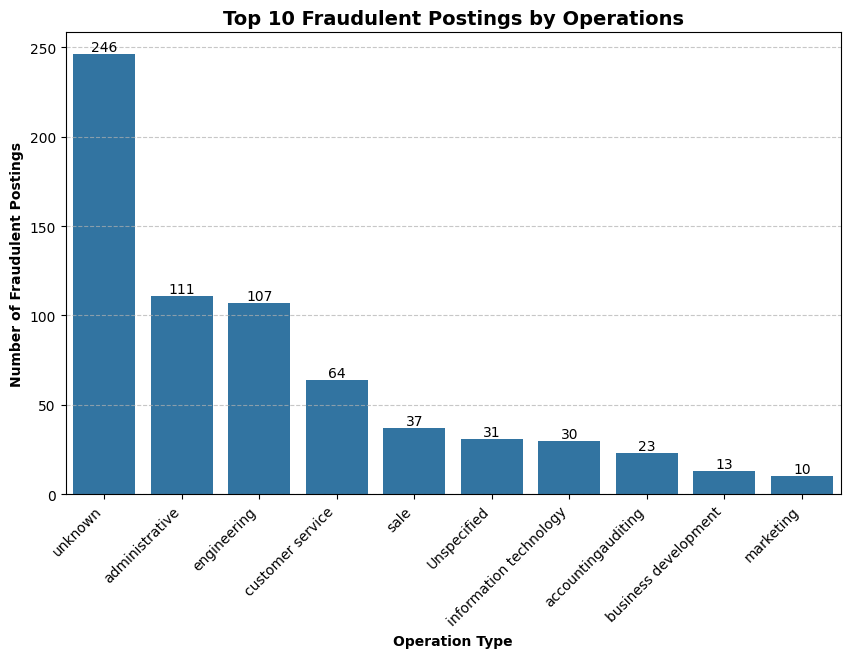

In [21]:
# Top 10 operations with highest fradulent job posting

top_10_operation = df.groupby('Operations')['Fraudulent'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_operation.index, y=top_10_operation.values, estimator=sum, errorbar=None)
plt.title('Top 10 Fraudulent Postings by Operations', fontsize=14, fontweight='bold')
plt.xlabel('Operation Type', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()


#### Relationship of Telecommunication with Fradulent Postings

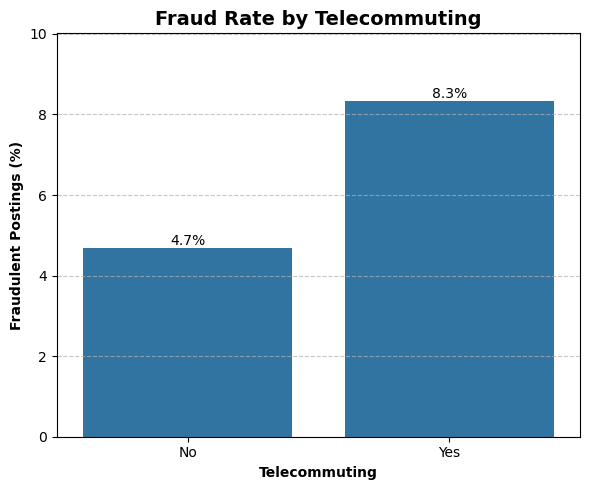

In [151]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Map 0/1 to 'No'/'Yes'
df['Telecommuting_Label'] = df['Telecomunication'].map({0: 'No', 1: 'Yes'})

# Calculate fraud rate
fraud_rate = df.groupby('Telecommuting_Label')['Fraudulent'].mean().reset_index()
fraud_rate['Fraudulent'] *= 100  # Convert to percentage

# Plot
plt.figure(figsize=(6, 5))
ax = sns.barplot(data=fraud_rate, x='Telecommuting_Label', y='Fraudulent')

# Annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)

plt.title('Fraud Rate by Telecommuting', fontsize=14, fontweight='bold')
plt.xlabel('Telecommuting', fontweight='bold')
plt.ylabel('Fraudulent Postings (%)', fontweight='bold')
ax.set_ylim(0, max(fraud_rate['Fraudulent']) * 1.2)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Distribution of fraudulent postings across cities

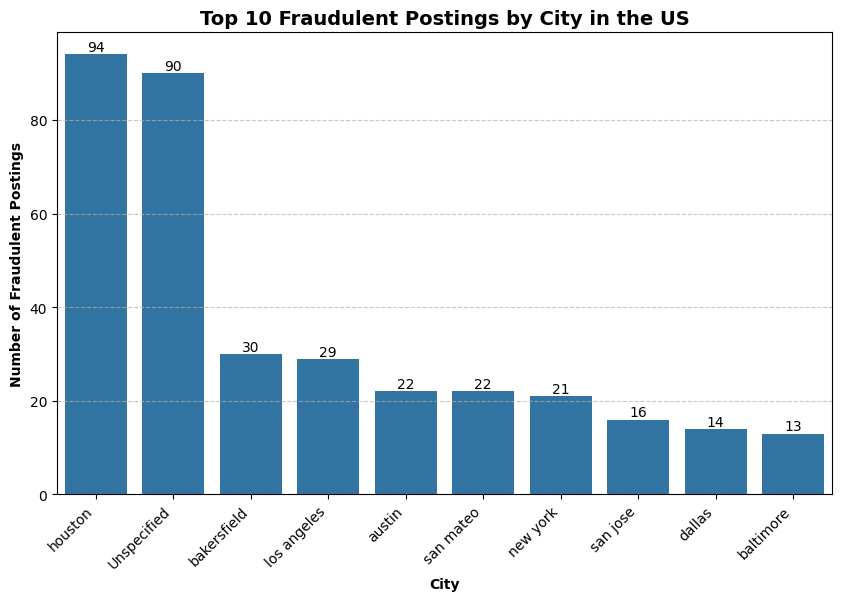

In [24]:
# top 10 city in US with the highest fradulent job posting
top_10_city_fraud = df.groupby('City')['Fraudulent'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_city_fraud.index, y=top_10_city_fraud.values, estimator=sum, errorbar=None)
plt.title('Top 10 Fraudulent Postings by City in the US', fontsize=14, fontweight='bold')
plt.xlabel('City', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()


### Textual Terms Analysis

#### Job description

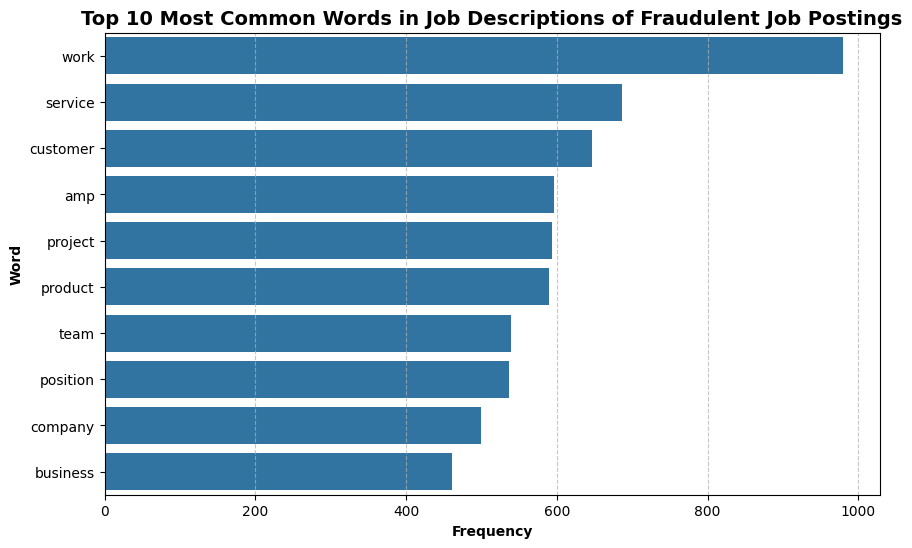

In [94]:
# top 10 most common words found in fraudulent job description

fraudulent_df = df[df['Fraudulent'] == 1]
fraudulent_posts = fraudulent_df['Job_Description']  

all_words = " ".join(fraudulent_posts).split()
all_words = [word for word in all_words if word != 'â']

word_counts = Counter(all_words)
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Plotting the top 10 most common words
top_10_words = word_freq_df.head(10)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Frequency', y='Word', data=top_10_words)
plt.title('Top 10 Most Common Words in Job Descriptions of Fraudulent Job Postings', fontsize=14, fontweight='bold')
plt.xlabel('Frequency', fontweight='bold')
plt.ylabel('Word', fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



#### Job Title

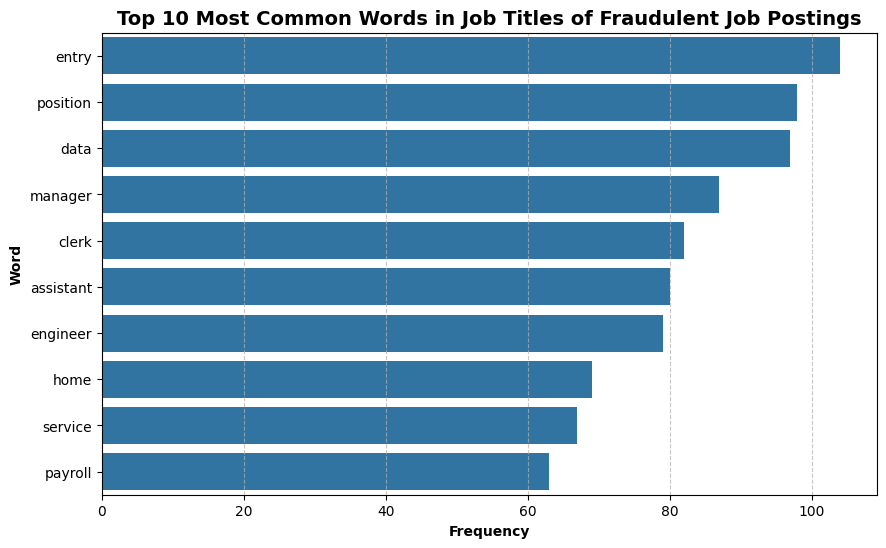

In [95]:
# top 10 most common words found in fraudulent profile

fraudulent_df = df[df['Fraudulent'] == 1]
fraudulent_posts = fraudulent_df['Job Title']  

all_words = " ".join(fraudulent_posts).split()


word_counts = Counter(all_words)
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Plotting the top 10 most common words
top_10_words = word_freq_df.head(10)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Frequency', y='Word', data=top_10_words)
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.title('Top 10 Most Common Words in Job Titles of Fraudulent Job Postings', fontsize=14, fontweight='bold')
plt.xlabel('Frequency', fontweight='bold')
plt.ylabel('Word', fontweight='bold')
plt.show()

#### Departments

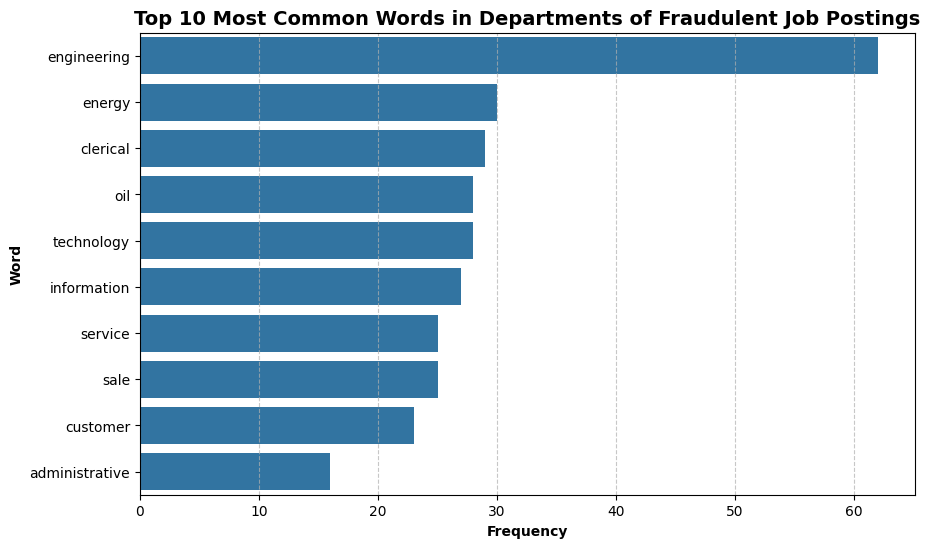

In [96]:
# top 10 most common words found in department of fradualent job posting 

fraudulent_df = df[df['Fraudulent'] == 1]
fraudulent_posts = fraudulent_df['Department']  

all_words = " ".join(fraudulent_posts).split()
all_words = [word for word in all_words if word not in ['â', 'unknown']]


word_counts = Counter(all_words)
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Plotting the top 10 most common words
top_10_words = word_freq_df.head(10)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Frequency', y='Word', data=top_10_words)
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.title('Top 10 Most Common Words in Departments of Fraudulent Job Postings', fontsize=14, fontweight='bold')
plt.xlabel('Frequency', fontweight='bold')
plt.ylabel('Word', fontweight='bold')
plt.show()

### Textual Length Analysis

#### Job Description

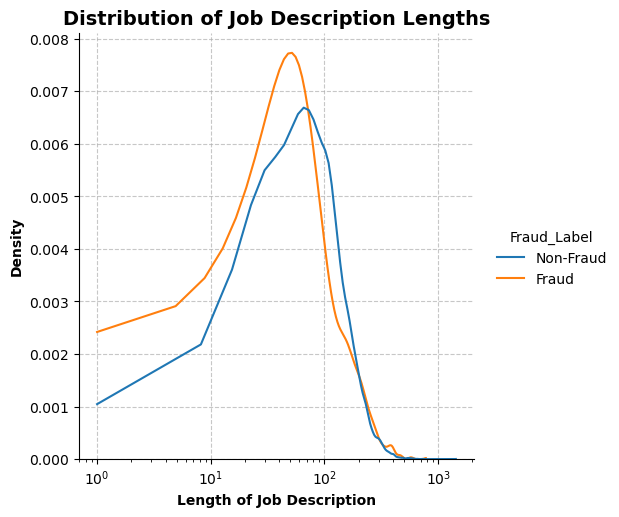

In [ ]:
# Map Fraudulent column to readable labels
df['Fraud_Label'] = df['Fraudulent'].map({1: 'Fraud', 0: 'Non-Fraud'})

# Calculate description length
df['Job_Description_Length'] = df['Job_Description'].apply(lambda x: len(str(x).split()))
ax = sns.displot(df, x='Job_Description_Length', hue='Fraud_Label', kind='kde', common_norm=False, cut=0)
ax.set(xscale="log")
plt.title('Distribution of Job Description Lengths', fontsize=14, fontweight='bold')
plt.xlabel('Length of Job Description', fontweight='bold')
plt.ylabel('Density', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



#### Job Profile

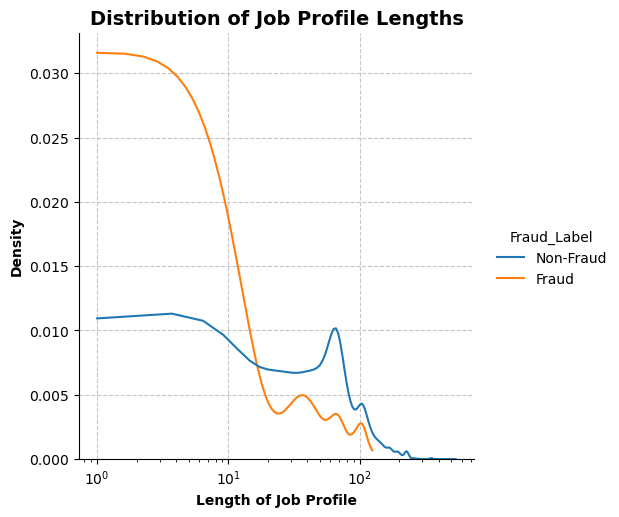

In [ ]:
# Plot of distribution of text length in job profile of fraudulent and non-fraudulent postings

# Map Fraudulent column to readable labels
df['Fraud_Label'] = df['Fraudulent'].map({1: 'Fraud', 0: 'Non-Fraud'})

# Calculate profile text length
df['Profile_Length'] = df['Profile'].apply(lambda x: len(str(x).split()))

# Plot
ax = sns.displot(df, x='Profile_Length', hue='Fraud_Label', kind='kde', common_norm=False, cut=0)
ax.set(xscale="log")

plt.title('Distribution of Job Profile Lengths', fontsize=14, fontweight='bold')
plt.xlabel('Length of Job Profile', fontweight='bold')
plt.ylabel('Density', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)

# Set legend title to bold
plt.legend(title='Posting Type', title_fontproperties={'weight': 'bold'})

plt.show()



#### Requirements

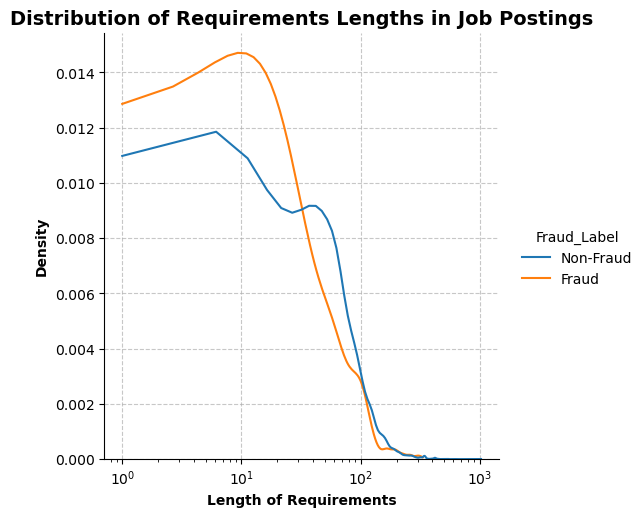

In [149]:
# Plot of distribution of text length in job requirements of fraudulent and non-fraudulent postings

# Map to readable labels
df['Fraud_Label'] = df['Fraudulent'].map({1: 'Fraud', 0: 'Non-Fraud'})

# Calculate length of requirements
df['Requirements_Length'] = df['Requirements'].apply(lambda x: len(str(x).split()))

# KDE plot
ax = sns.displot(df, x='Requirements_Length', hue='Fraud_Label', kind='kde', common_norm=False, cut=0)
ax.set(xscale="log")

# Title and labels
plt.title('Distribution of Requirements Lengths in Job Postings', fontsize=14, fontweight='bold')
plt.xlabel('Length of Requirements', fontweight='bold')
plt.ylabel('Density', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()



#### Job Benefits

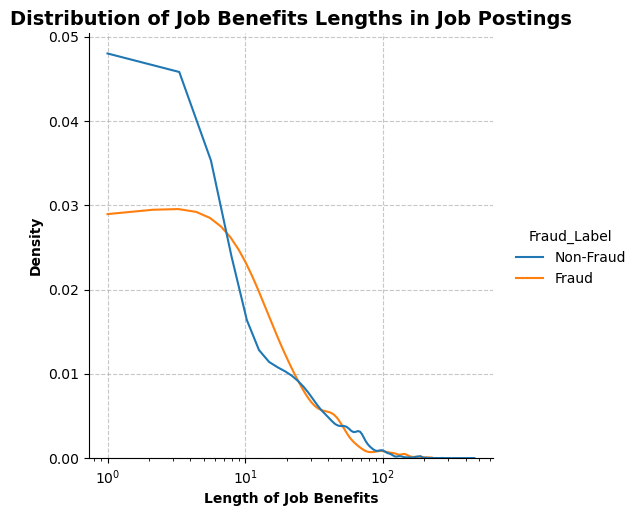

In [150]:
# Plot of distribution of text length in job benefits of fraudulent and non-fraudulent postings

# Map labels for clarity
df['Fraud_Label'] = df['Fraudulent'].map({1: 'Fraud', 0: 'Non-Fraud'})

# Calculate benefits text length
df['Job_Benefits_Length'] = df['Job_Benefits'].apply(lambda x: len(str(x).split()))

# KDE plot
ax = sns.displot(df, x='Job_Benefits_Length', hue='Fraud_Label', kind='kde', common_norm=False, cut=0)
ax.set(xscale="log")

# Add labels and grid
plt.title('Distribution of Job Benefits Lengths in Job Postings', fontsize=14, fontweight='bold')
plt.xlabel('Length of Job Benefits', fontweight='bold')
plt.ylabel('Density', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)


plt.show()
